# Testing experimentally bounding deviations from quantum theory in the landscape of generalized probabilistic theories

## Article

https://arxiv.org/abs/1710.05948

In [217]:
import sys
import numpy as np
import scipy as sp
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.providers.aer.extensions.snapshot_statevector import *
from math import pi, sqrt
import cvxopt
from cvxopt import matrix, solvers
import quadprog
import quantum_decomp as qdp
import matplotlib
from matplotlib import pyplot as plt

## Experiment

### First Test

In the first test we prepare $n=100$ preparations and $m=100$ measurement settings. First we create a function that generates $n$ equally distanced points or states on the surface of the bloch sphere.

In [2]:
def gen_eq_bloch_states(n, C=3.6, return_angles=True):
    '''
    Generates equally spaced points on the bloch sphere through a spiral. 
    See here: https://www.intlpress.com/site/pub/files/_fulltext/journals/mrl/1994/0001/0006/MRL-1994-0001-0006-a003.pdf

    ==========
    Parameters
    ----------
    n (type=int): the number of points to be generated evenly on the sphere
    C (type=float, default=3.6): constant that makes sure that succesive points 
                                 on S^2 will be the same Euclidean distance apart
    return_angles (type=boolean, default=True): whether to also return the angles 
                                                associated with each state
    ==========
    
    ======
    Return
    ------
    (type=numpy.array): an array for n evenly spaced coordinates on the block sphere, 
                         with their associated angles if needed
    ======
    '''
    states = np.zeros((n, 2), dtype=complex)
    h = np.zeros(n)
    theta = np.zeros(n)
    phi = np.zeros(n)
    
    # initialize
    h[0] = -1
    h[n-1] = -1 + 2*(n-1)/(n-1)
    theta[0] = np.arccos(h[0])
    theta[n-1] = np.arccos(h[n-1]) 
    phi[0] = 0
    phi[n-1] = 0
    states[0] = [np.cos(theta[0]/2), np.sin(theta[0]/2)*np.exp(1j*phi[0])]
    states[n-1] = [np.cos(theta[n-1]/2), np.sin(theta[n-1]/2)*np.exp(1j*phi[n-1])]
    
    # the rest of the states
    for k in range(1, n-1):
        h[k] = -1 + 2*(k)/(n-1)
        theta[k] = np.arccos(h[k])
        phi[k] = np.mod(phi[k] + C/(sqrt(n)*sqrt(1 - h[k]**2)), 2*pi)
        states[k] = [np.cos(theta[k]/2), np.sin(theta[k]/2)*np.exp(1j*phi[k])]
    
    if return_angles==True:
        return [states, theta, phi]
    else:
        return states

Next, we create circuits to simulate 100 preparations and 100 measurements. We will prepare 100 states of the form:

\\[\{|\psi_i>\}_{i=1}^{100}\\]

These states are uniformly distributed on the bloch sphere as implemented by the function above.

We will then implement the measurements with the following projective measurements:

\\[\{(|\psi_i><\psi_i|, \mathbb{I}-|\psi_i><\psi_i|)\}_{i=1}^{100}\\]

In [241]:
# get backend
backend = Aer.get_backend("aer_simulator")

# get list of n*m evenly distributed states on the bloch sphere
n = 100 # number of preparations
m = 100 # number of measurements
states_info = gen_eq_bloch_states(n)
F = np.zeros((n, m), dtype=float) # frequency matrix
var = np.zeros((n, m), dtype=float) # variance matrix

# loop through the preparations and measurements
for i in range(n):
    for j in range(m):
        qc = QuantumCircuit(1) # single qubit circuit
        state_i = states_info[0][i] #if j != 0 else states_info[0][0]
        state_j = states_info[0][j] if j != 0 else states_info[0][i]
        
        theta_j = states_info[1][j] if j != 0 else states_info[1][i]
        phi_j = states_info[2][j] if j != 0 else states_info[2][i]
        antipodal_state_j = [np.cos((theta_j+pi)/2), np.sin((theta_j+pi)/2)*np.exp(1j*phi_j)]
        
        a = state_j[0]
        b = antipodal_state_j[0]
        c = state_j[1]
        d = antipodal_state_j[1]
        A = np.array([[a, b], [c, d]], dtype=complex)
        #print(A)
        qc_gates = qdp.matrix_to_qiskit_circuit(A)
        #print(qc_gates)
        
        # angles
        #phi_j = states_info[2][j] if j != 0 else states_info[2][i]
        #theta_j = states_info[1][j] if j != 0 else states_info[1][i]
        #x = np.sin(theta_j)*np.cos(phi_j)
        #y = np.sin(theta_j)*np.sin(phi_j)
        #z = np.cos(theta_j)
        #alpha_xz = np.arctan(x/z) if (x != 0 and y != 0 and theta_j != 0) else theta_j
        #alpha_yz = np.arctan(y/z)
        
        # construct circuits
        qc.initialize(state_i)
        qc.barrier()
        #qc.rz(-2*phi_j, 0)
        #qc.rx(-theta_j, 0)
        #qc.rz(phi_j, 0)
        qc += qc_gates.inverse()
        #qc.snapshot_statevector('label')
        qc.measure_all()
        
        # Transpile for simulator
        backend = Aer.get_backend('aer_simulator')
        qc = transpile(qc, backend)

        # Run and get counts
        runs = 1000
        result = backend.run(qc, shots=runs).result()
        counts = result.get_counts(qc)
        #print(result.data()['snapshots'])
        #print(counts)
        
        # calculate frequency matrix and variance matrix
        zero_meas = counts.get('0') if not counts.get('0') is None else 0
        F[i][j] = zero_meas/runs
        avg = (runs - zero_meas)/runs
        var[i][j] = 1/(runs - 1)*((zero_meas*(avg**2))+((runs - zero_meas)*((1 - avg)**2)))

[[1.    0.983 0.985 ... 0.014 0.017 0.   ]
 [1.    1.    0.993 ... 0.057 0.039 0.011]
 [1.    0.998 1.    ... 0.077 0.051 0.022]
 ...
 [1.    0.066 0.079 ... 1.    0.994 0.98 ]
 [1.    0.035 0.056 ... 0.995 1.    0.993]
 [1.    0.013 0.027 ... 0.981 0.995 1.   ]]


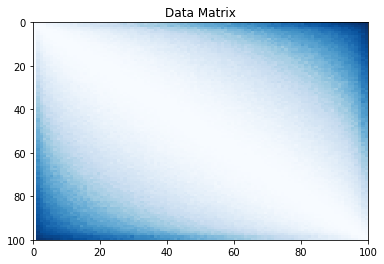

In [252]:
W = np.zeros((n*m, m*n), dtype=float) # W = 1/var
index = 0

for i in range(n):
    for j in range(m):
        W[index][index] = 1/(var[i][j]) if var[i][j] != 0 else 1000000
    index += 1

print(F)
#print(var)

plt.title("Data Matrix")
graph = plt.pcolormesh(F, cmap=matplotlib.pyplot.cm.Blues_r)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [253]:
def vec(M):
    '''
    Converts an n x m matrix into a column vector, where the first n entries
    corresponds to the first column of the matrix, the next n entries to the 
    second column, and so on.
    
    https://stackoverflow.com/a/25248378

    ==========
    Parameters
    ----------
    S (type=numpy.array): the matrix to use for the column vector
    ==========
    
    ======
    Return
    ------
    (type=numpy.array): the column vector
    ======
    '''
    return M.reshape((-1, 1), order="F")

def mat(v, n, m, dty=float):
    '''
    Converts a vector of length n*m to an n x m matrix where the first n entries
    corresponds to the first column of the matrix, the next n entries to the 
    second column, and so on.
    
    ==========
    Parameters
    ----------
    v (type=numpy.array): the array to use for the matrix
    n (type=int): number of rows for the matrix
    m (type=int): number of columns for the matrix
    dty (type=type): type of the matrix
    ==========
    
    ======
    Return
    ------
    (type=numpy.array): the matrix
    ======
    '''
    M = np.zeros((n, m), dtype=dty)
    for i in range(n):
        for j in range(m):
            M[i][j] = v[n*j + i]
    return M

def is_pos_semi_def(A, tol=1e-8):
    E = np.linalg.eigvalsh(A)
    return np.all(E > -tol)

def S_min(S, E, F, W, m):
    I_m = np.identity(m)
    A_1 = np.transpose(vec(S)) @ (np.kron(E, I_m)) @ W @ (np.kron(np.transpose(E), I_m)) @ vec(S)
    A_2 = 2 * np.transpose(vec(S)) @ (np.kron(E, I_m)) @ W @ vec(F)
    A = A_1 - A_2
    return A[0][0]

def E_min(E, S, F, W, n):
    I_n = np.identity(n)
    A_1 = np.transpose(vec(E)) @ np.transpose(np.kron(I_n, S)) @ W @ (np.kron(I_n, S)) @ vec(E)
    A_2 = 2 * np.transpose(vec(E)) @ np.transpose(np.kron(I_n, S)) @ W @ vec(F)
    A = A_1 - A_2
    return A[0][0]

def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -numpy.vstack([A, G]).T
        qp_b = -numpy.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

def wrla_1(U, V, A, W):
    A_tilda = U @ V
    summation = 0
    w = 0
    for i in range(len(A)):
        for j in range(len(A[0])):
            summation += W[w][w] * ((A[i][j] - A_tilda[i][j])**2)
    return summation

def wrla_2(V, U, A, W):
    A_tilda = U @ V
    summation = 0
    w = 0
    for i in range(len(A)):
        for j in range(len(A[0])):
            summation += W[w][w] * ((A[i][j] - A_tilda[i][j])**2)
    return summation

In [254]:
def s_min(E, W, F, n, m):
    '''
    Function that minimizes the estimated state space, S, with a fixed effect space
    according to the following quadratic program:
    
    minimize_{S} vec(S)^T @ (E x I_n) @ W (E^T x I_n) vec(S) - 2 vec(S)^T @ (E x I_n) @ W @ vec(F)
    
    subject to 0 <= (E^T x I_n) @ vec(S) <= 1 (element wise inequality)
    
    ==========
    Parameters
    ----------
    E (type=numpy.array): fixed effect space matrix; dim = k x m
    W (type=numpy.array): matrix that encodes the uncertainties along the diagonal 
                          for each preparation/measurement pair; dim = n*m x n*m
    F (type=numpy.array): data matrix; dim = n x m
    n (type=int): number of preparations
    m (type=int): number of measurements
    ==========
    
    ======
    Return
    ------
    (type=numpy.array): the solution to the quadratic program
    ======
    '''
    I_n = np.identity(n, dtype=float)
    P = 2 * (np.kron(E, I_n)) @ W @ (np.kron(np.transpose(E), I_n))
    q = -2 * np.kron(E, I_n) @ W @ vec(F)
    G_0 = -np.kron(np.transpose(E), I_n)
    G_1 = np.kron(np.transpose(E), I_n)
    h_0 = (np.zeros(n*m))
    h_1 = (np.ones(n*m))
    
    P = matrix(P)
    q = matrix(q)
    G = matrix(np.concatenate([G_0, G_1]))
    h = matrix(np.concatenate([h_0, h_1]))
    
    return solvers.qp(P, q, G, h)

def e_min(S, W, F, n, m):
    '''
    Function that minimizes the estimated effect space, E, with a fixed state space
    according to the following quadratic program:
    
    minimize_{E} vec(E)^T @ (I_m x S)^T @ W (I_m x S) vec(S) - 2 vec(S)^T @ (I_m x S)^T @ W @ vec(F)
    
    subject to 0 <= (I_m x S) @ vec(E) <= 1 (element wise inequality)
    
    ==========
    Parameters
    ----------
    S (type=numpy.array): fixed state space matrix; dim = k x m
    W (type=numpy.array): matrix that encodes the uncertainties along the diagonal 
                          for each preparation/measurement pair; dim = n*m x n*m
    F (type=numpy.array): data matrix; dim = n x m
    n (type=int): number of preparations
    m (type=int): number of measurements
    ==========
    
    ======
    Return
    ------
    (type=numpy.array): the solution to the quadratic program
    ======
    '''
    I_m = np.identity(m, dtype=float)
    P = 2 * (np.transpose(np.kron(I_m, S))) @ W @ (np.kron(I_m, S))
    q = -2 * np.transpose(np.kron(I_m, S)) @ W @ vec(F)
    G_0 = -np.kron(I_m, S)
    G_1 = np.kron(I_m, S)
    h_0 = (np.zeros(n*m))
    h_1 = (np.ones(n*m))
    
    P = matrix(P)
    q = matrix(q)
    G = matrix(np.concatenate([G_0, G_1]))
    h = matrix(np.concatenate([h_0, h_1]))
    
    return solvers.qp(P, q, G, h)

def chi_squared(S, E, F, W, n, m):
    '''
    Calculates the weighted chi^2 value.

    ==========
    Parameters
    ----------
    S (type=numpy.array): state space matrix; dim = n x k
    E (type=numpy.array): effect space matrix; dim = k x m
    F (type=numpy.array): data matrix; dim = n x m
    W (type=numpy.array): matrix that encodes the uncertainties along the diagonal 
                          for each preparation/measurement pair; dim = n*m x n*m
    n (type=int): number of preparations
    m (type=int): number of measurements
    ==========
    
    ======
    Return
    ------
    (type=float): the chi^2 value
    ======
    '''
    sum = 0
    w_index = 0
    D = S @ E
    for i in range(n):
        for j in range(m):
            sum += ((F[i][j] - D[i][j]))**2 * W[w_index][w_index]
            w_index += 1
    return sum

In [255]:
def bfp(k, E_0, S_0, F, W, n, m, max_iterations=5000, convergence_threshold=10E-6):
    '''
    Finds the low-rank matrix that best fits the data matrix of frequencies.  

    ==========
    Parameters
    ----------
    k (type=int): rank of best-fit matrix
    E_0 (type=numpy.array): initial estimate of effect space matrix; dim = k x m
    F (type=numpy.array): data matrix; dim = n x m
    W (type=numpy.array): matrix that encodes the uncertainties along the diagonal 
                          for each preparation/measurement pair; dim = n*m x n*m
    n (type=int): number of preparations
    m (type=int): number of measurements
    max_iterations (type=int, default=5000): the max number of iterations to go through
                                             for the optimization
    convergence_threshold (type=float, default=10E-16): the convergence threshold for 
                                                        the optimization
    ==========
    
    ======
    Return
    ------
    (type=numpy.array): an array that contains the estimated state space and effect space matrices
    ======
    '''
    #S = np.zeros((n, k), dtype=float)
    S = S_0
    E = E_0
    chi_squared_prev = 0
    chi_squared_curr = 0
    iteration = 1
    while (True):
        chi_squared_prev = chi_squared_curr
        S = mat(s_min(E, W, F, n, m)['x'], n, k)
        #S = mat(sp.optimize.minimize(wrla_1, S, args=(E, F, W,), bounds=sp.optimize.Bounds(np.zeros(n*k), np.ones(n*k))), n, k)
        E = mat(e_min(S, W, F, n, m)['x'], k, m)
        #E = mat(sp.optimize.minimize(wrla_2, E, args=(S, F, W,), bounds=sp.optimize.Bounds(np.zeros(n*k), np.ones(n*k))), k, m)
        chi_squared_curr = chi_squared(S, E, F, W, n, m)
        if (iteration == max_iterations or (chi_squared_curr -  chi_squared_prev) < convergence_threshold):
            break
        iteration += 1
    return [S, E]

In [256]:
U, s, Vh = np.linalg.svd(F)
s = np.sort(s)[::-1]
#print(s)
S = np.diag(s)
S_0 = U
E_0 = S @ Vh

candidate_k = {2, 3, 4, 5}
for k in candidate_k:
    S_k = np.diag(s[0:k])
    Vh_k = Vh[0:k, 0:len(Vh[0])]
    U_k = U[0:len(U), 0:k]
    S_0 = U_k @ S_k
    E_0 = S_k @ Vh_k
    D_array = bfp(k, E_0, S_0, F, W, n, m)
    print(D_array[0] @ D_array[1])

     pcost       dcost       gap    pres   dres
 0: -2.0010e+06 -2.0158e+06  1e+04  2e-17  2e-16
 1: -2.0010e+06 -2.0017e+06  7e+02  2e-16  1e-16
 2: -2.0010e+06 -2.0011e+06  8e+01  2e-16  9e-17
 3: -2.0011e+06 -2.0011e+06  8e+00  2e-16  2e-16
 4: -2.0011e+06 -2.0011e+06  3e-01  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0011e+06 -2.0160e+06  4e+04  1e+00  9e-17
 1: -2.0011e+06 -2.0079e+06  7e+03  1e-02  7e-17
 2: -2.0011e+06 -2.0012e+06  2e+02  3e-04  1e-16
 3: -2.0011e+06 -2.0011e+06  3e+00  5e-06  5e-17
 4: -2.0011e+06 -2.0011e+06  7e-02  5e-08  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0011e+06 -2.0160e+06  4e+04  1e+00  7e-16
 1: -2.0011e+06 -2.0079e+06  7e+03  1e-02  2e-16
 2: -2.0011e+06 -2.0013e+06  2e+02  4e-04  9e-17
 3: -2.0011e+06 -2.0011e+06  4e+00  7e-06  7e-17
 4: -2.0011e+06 -2.0011e+06  1e-01  1e-07  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 

ValueError: Rank(A) < p or Rank([P; A; G]) < n

In [ ]:
def aic(k, chi_squared_k, m, n):
    r_k = k*(m + n - k)
    return chi_squared_k + r_k